In [12]:
import keras
from keras import layers
import tensorflow as tf
import numpy as np
import datetime, os

In [2]:
%load_ext tensorboard

True
Found 2002 images belonging to 2 classes.
Found 479 images belonging to 2 classes.


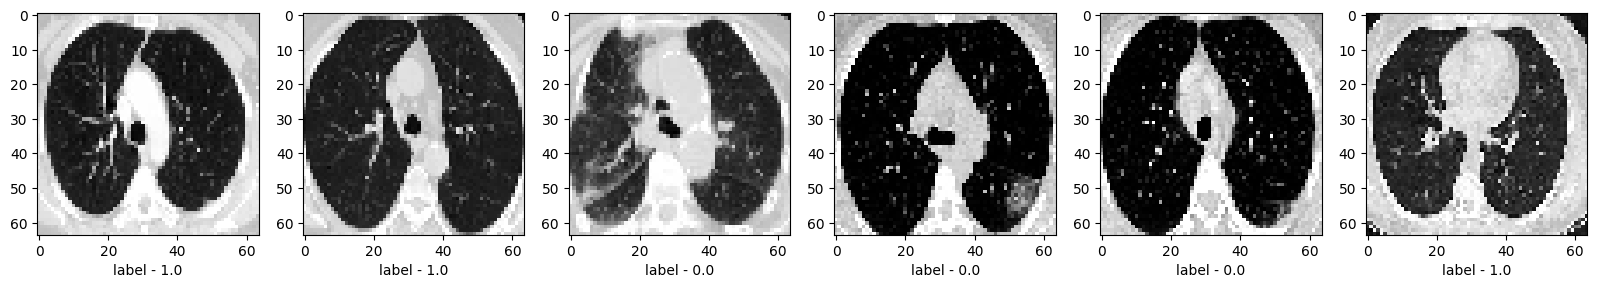

(2002, 64, 64, 1)
(479, 64, 64, 1)


In [3]:
%run data_input.ipynb
print(x_train.shape)
print(x_test.shape)

In [4]:
# x_train = train.astype('float32') / 255.
# x_test = test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(2002, 4096)
(479, 4096)


In [5]:
from keras import regularizers
encoding_dim = 4096
input_img = keras.Input(shape=(4096, ))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(4096, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [6]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [7]:
#This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [8]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [9]:
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 4096)              16781312  
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
Total params: 33,562,624
Trainable params: 33,562,624
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (No

In [13]:
# If a metric doesn’t change by a minimum delta in a given number of epochs,
# the EarlyStopping callback kills the training process.
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='max',
    min_delta=0.001,
    patience=10,
    verbose=1
    #restore_best_weights = False
)
# restore_best_weights: if set to True, the model will get the weights of the epoch
# which has the best value for the monitored metrics;
# otherwise, it will get the weights of the last epoch.

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [17]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=8,
                shuffle=True,
                validation_data=(x_test, x_test),
               callbacks = [cb_earlystop, tensorboard_callback])

Epoch 1/50
251/251 [==============================] - 194s 770ms/step - loss: 0.0286 - val_loss: 0.0223
Epoch 2/50
251/251 [==============================] - 58s 192ms/step - loss: 0.0202 - val_loss: 0.0197
Epoch 3/50
251/251 [==============================] - 37s 149ms/step - loss: 0.0175 - val_loss: 0.0179
Epoch 4/50
251/251 [==============================] - 38s 150ms/step - loss: 0.0162 - val_loss: 0.0175
Epoch 5/50
251/251 [==============================] - 38s 150ms/step - loss: 0.0154 - val_loss: 0.0170
Epoch 6/50
251/251 [==============================] - 38s 151ms/step - loss: 0.0145 - val_loss: 0.0169
Epoch 7/50
251/251 [==============================] - 38s 151ms/step - loss: 0.0140 - val_loss: 0.0157
Epoch 8/50
251/251 [==============================] - 38s 150ms/step - loss: 0.0136 - val_loss: 0.0156
Epoch 9/50
251/251 [==============================] - 37s 149ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 10/50
251/251 [==============================] - 37s 149ms/step - 

In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

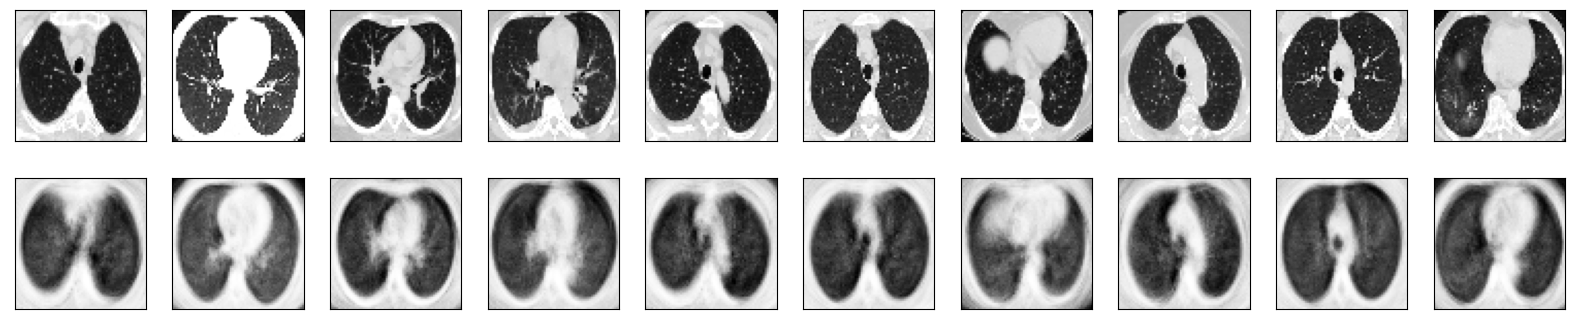

In [19]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
start = 50
plt.figure(figsize=(20, 4))
for i in range(start, start+n):
    # Display original
    ax = plt.subplot(2, n, i + 1 - start)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n - start)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
%tensorboard --logdir logs